In [28]:
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC
import yfinance as yf

import pyfolio as pf
from stable_baselines3.common.vec_env import DummyVecEnv

from config.config import trade_end_date
from env.train_env import StockEnvTrain
from env.trade_env import StockEnvTrade
from config import config
from preprocessing.preprocessors import *
from run_DRL import run_model

import logging
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [29]:
config.dj_start_date = '2009-01-01'
config.dj_end_date = '2024-10-31'
config.init_turbulence_sample_start_date = 20090000
config.init_turbulence_sample_end_date = 20191000
config.trade_start_date = 20160101
config.trade_end_date = 20241031

# For debug purpose, to be removed
config.results_dir = 'results/test'
config.trained_model_dir = 'trained_models/test'

In [30]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = pd.to_datetime(strategy_ret.index)
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts


def train_and_test_agent(df, env_train, agent_class, model_name, timestep, train_start_date, train_end_date, trade_start_date, trade_end_date, is_initial, last_state):
    # Retrieve the trained agent of the corresponding period
    logging.info(f"======Individual Agent Trained Retrieved from {train_start_date} to {train_end_date}========")
    logging.info(f"Training model: {model_name}")
    # agent = agent_class('MlpPolicy', env_train, verbose=0)
    # agent.learn(total_timesteps=timestep)

    model_path = f"{config.trained_model_dir}/{model_name}_{trade_end_date}.zip"
    if os.path.exists(model_path):
        logging.info(f"Loading existing model: {model_name} from {model_path}")
        agent = agent_class.load(model_path, env=env_train)
    else:
        raise FileNotFoundError(f"Model {model_name} for period ending {trade_end_date} not found.")

    # Prepare trade environment
    logging.info(f"======{model_name} Individual Agent Trading from {trade_start_date} to {trade_end_date}======")
    trade = data_split(df, start=trade_start_date, end=trade_end_date)
    env_trade = DummyVecEnv([lambda: StockEnvTrade(trade,
                                                   turbulence_threshold=1e6,
                                                   is_initial=is_initial,
                                                   previous_state=last_state,
                                                   model_name=model_name,
                                                   iteration=trade_end_date,
                                                   seed=42)])
    obs_trade = env_trade.reset()
    done = False
    last_state = []

    while not done:
        action, _states = agent.predict(obs_trade, deterministic = True)
        obs_trade, rewards, done, info = env_trade.step(action)
    last_state = info[0]['terminal_observation']

    # Save last state
    pd.DataFrame({'last_state': list(last_state)}).to_csv(
        f'{config.results_dir}/last_state_{model_name}_{trade_end_date}.csv', index=False)

    # Load account value for the strategy
    df_model = pd.read_csv(f'{config.results_dir}/account_value_trade_{model_name}_{trade_end_date}.csv')
    df_model['Date'] = pd.to_datetime(df_model['datadate'], format='%Y%m%d')
    # df_model['daily_return'] = df_model['account_value'].pct_change(1)
    df_model['name'] =  model_name
    return df_model, last_state

## 1. Display the performance of the ensemble strategy

In [31]:
df = pd.read_csv(f"done_data_{config.dj_start_date}_{config.dj_end_date}.csv")
unique_trade_date = df[(df.datadate > config.trade_start_date)
                       & (df.datadate <= config.trade_end_date)].datadate.unique()

# Retrieve the account value for the ensemble strategy
df_account_value = pd.DataFrame()
for i in range(config.rebalance_window + config.validation_window, len(unique_trade_date) + 1, config.rebalance_window):
    temp = pd.read_csv(
        f'{config.results_dir}/account_value_trade_ensemble_{unique_trade_date[i]}.csv')
    df_account_value = df_account_value.append(temp, ignore_index=True)

df_account_value['datadate'] = pd.to_datetime(df_account_value['datadate'], format='%Y%m%d')
df_account_value['daily_return'] = df_account_value['account_value'].pct_change(1)
df_account_value['cumret'] = (1 + df_account_value['daily_return']).cumprod() - 1
df_account_value.head()

,datadate,account_value,daily_return,cumret
0,2016-04-05,1.000000e+06,NaN,NaN
1,2016-04-06,1.000053e+06,0.000053,0.000053
2,2016-04-07,9.997756e+05,-0.000278,-0.000224
3,2016-04-08,9.997184e+05,-0.000057,-0.000282
4,2016-04-11,9.996536e+05,-0.000065,-0.000346


## 2. Display the performance of the DJI Index

In [32]:
# Import DJI Index Data
ticker = "^DJI"
start_date = df_account_value['datadate'].min().strftime('%Y-%m-%d')
end_date = df_account_value['datadate'].max().strftime('%Y-%m-%d')

dji_data = yf.download(ticker, start=start_date, end=end_date)
dji_data['daily_return'] = dji_data['Adj Close'].pct_change(1)
dji_data['cumret'] = (1 + dji_data['daily_return']).cumprod() - 1
dji_data.reset_index(inplace=True)
dji_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,cumret


## 3. Display the performance of individual agents

In [33]:
a2c, ddpg, ppo, td3, sac = [pd.DataFrame(), []], [pd.DataFrame(), []], [pd.DataFrame(), []], [pd.DataFrame(), []], [pd.DataFrame(), []]
df_agents = pd.DataFrame()

for i in range(config.rebalance_window + config.validation_window, len(unique_trade_date), config.rebalance_window):
    train_start_date = config.init_turbulence_sample_start_date
    train_end_date = unique_trade_date[i - config.rebalance_window - config.validation_window]
    trade_start_date = unique_trade_date[i - config.rebalance_window]
    trade_end_date = unique_trade_date[i]
    is_initial = (i - config.rebalance_window - config.validation_window == 0)
    train = data_split(df, start=train_start_date, end=train_end_date)
    env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

    a2c = train_and_test_agent(df, env_train, A2C, "A2C_30k_dow", 30000, train_start_date, train_end_date,
                                  trade_start_date, trade_end_date, is_initial, last_state= a2c[1])
    ddpg = train_and_test_agent(df, env_train, DDPG, "DDPG_10k_dow", 5000, train_start_date, train_end_date,
                                   trade_start_date, trade_end_date, is_initial, last_state= ddpg[1])
    ppo = train_and_test_agent(df, env_train, PPO, "PPO_100k_dow", 80000, train_start_date, train_end_date,
                                  trade_start_date, trade_end_date, is_initial, last_state= ppo[1])
    td3 = train_and_test_agent(df, env_train, TD3, "TD3_30k_dow", 10000, train_start_date, train_end_date,
                                   trade_start_date, trade_end_date, is_initial, last_state= td3[1])
    sac = train_and_test_agent(df, env_train, SAC, "SAC_30k_dow", 10000, train_start_date, train_end_date,
                                   trade_start_date, trade_end_date, is_initial, last_state= sac[1])
    df_agents = pd.concat([df_agents, a2c[0], ddpg[0], ppo[0], td3[0], sac[0]], axis=0)

# Plot the performance of the agents
df_agents = df_agents.sort_values(by='Date').reset_index(drop=True)
df_agents['daily_return'] = df_agents.groupby('name')['account_value'].pct_change(1)
df_agents['cumret'] = df_agents.groupby('name')['daily_return'].apply(lambda x: (1 + x).cumprod() - 1)
df_agents.head(10)

,datadate,account_value,Date,name,daily_return,cumret
0,20160405,1.000000e+06,2016-04-05,A2C_30k_dow,NaN,NaN
1,20160405,1.000000e+06,2016-04-05,TD3_30k_dow,NaN,NaN
2,20160405,1.000000e+06,2016-04-05,DDPG_10k_dow,NaN,NaN
3,20160405,1.000000e+06,2016-04-05,SAC_30k_dow,NaN,NaN
4,20160405,1.000000e+06,2016-04-05,PPO_100k_dow,NaN,NaN
5,20160406,1.000518e+06,2016-04-06,DDPG_10k_dow,0.000518,0.000518
6,20160406,1.000053e+06,2016-04-06,PPO_100k_dow,0.000053,0.000053
7,20160406,1.000711e+06,2016-04-06,TD3_30k_dow,0.000711,0.000711
8,20160406,1.000031e+06,2016-04-06,SAC_30k_dow,0.000031,0.000031
9,20160406,1.000262e+06,2016-04-06,A2C_30k_dow,0.000262,0.000262


## 4. Plot the performance of the ensemble strategy, DJI Index and individual agents

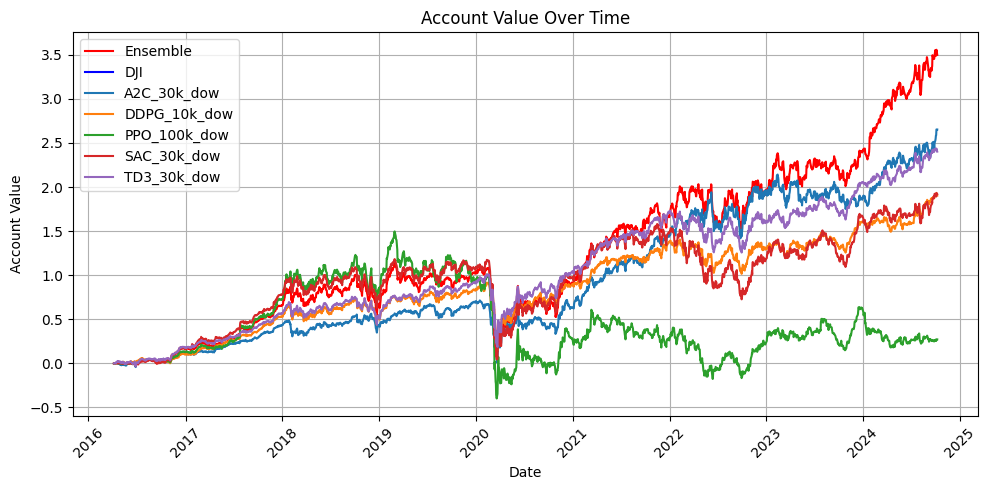

In [34]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(df_account_value['datadate'], df_account_value['cumret'], linestyle='-', color='r', label = 'Ensemble')
plt.plot(dji_data['Date'], dji_data['cumret'], linestyle='-', color='b', label='DJI')
for name, group in df_agents.groupby('name'):
    plt.plot(group['Date'], group['cumret'], linestyle='-', label=name)

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## 5. Display the performance comparison

In [35]:
def cal_performance_metrics(df):
    metrics = {}
    metrics['Cumulative Return'] = (df['cumret'].iloc[-1] - 1) * 100
    
    # Annualized Return
    trading_days = len(df)
    annual_factor = 252 / trading_days
    metrics['Annual Return'] = (df['cumret'].iloc[-1] + 1) ** annual_factor - 1
    metrics['Annual Return'] = metrics['Annual Return'] * 100
    
    metrics['Annual Volatility'] = df['daily_return'].std() * np.sqrt(252) * 100
    metrics['Sharpe Ratio'] = metrics['Annual Return'] / metrics['Annual Volatility']
    
    rolling_max = df['cumret'].cummax()
    drawdown = df['cumret'] - rolling_max
    max_drawdown = drawdown.min()
    metrics['Max Drawdown'] = max_drawdown * 100
    
    return metrics

In [36]:
performance_results = {}
for name, group in df_agents.groupby('name'):
    performance_results[name] = cal_performance_metrics(group)

performance_results['Ensemble'] = cal_performance_metrics(df_account_value)
# TODO: Add DJI Index
# performance_results['DJI'] = cal_performance_metrics(dji_data)

performance_df = pd.DataFrame(performance_results).T
performance_df.index.name = 'Strategy'

performance_df

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Strategy,,,,,
A2C_30k_dow,165.207829,16.461180,20.433705,0.805590,-70.668175
DDPG_10k_dow,90.234489,13.355099,18.582651,0.718686,-76.883223
PPO_100k_dow,-72.804143,2.870520,37.195093,0.077175,-189.412142
SAC_30k_dow,91.909890,13.431886,25.205741,0.532890,-113.714071
TD3_30k_dow,140.143836,15.491106,19.409643,0.798114,-82.174556
Ensemble,249.945690,19.355480,24.046199,0.804929,-101.210308


## 6. Compare the performance during volatile periods
We take 2020 as an example

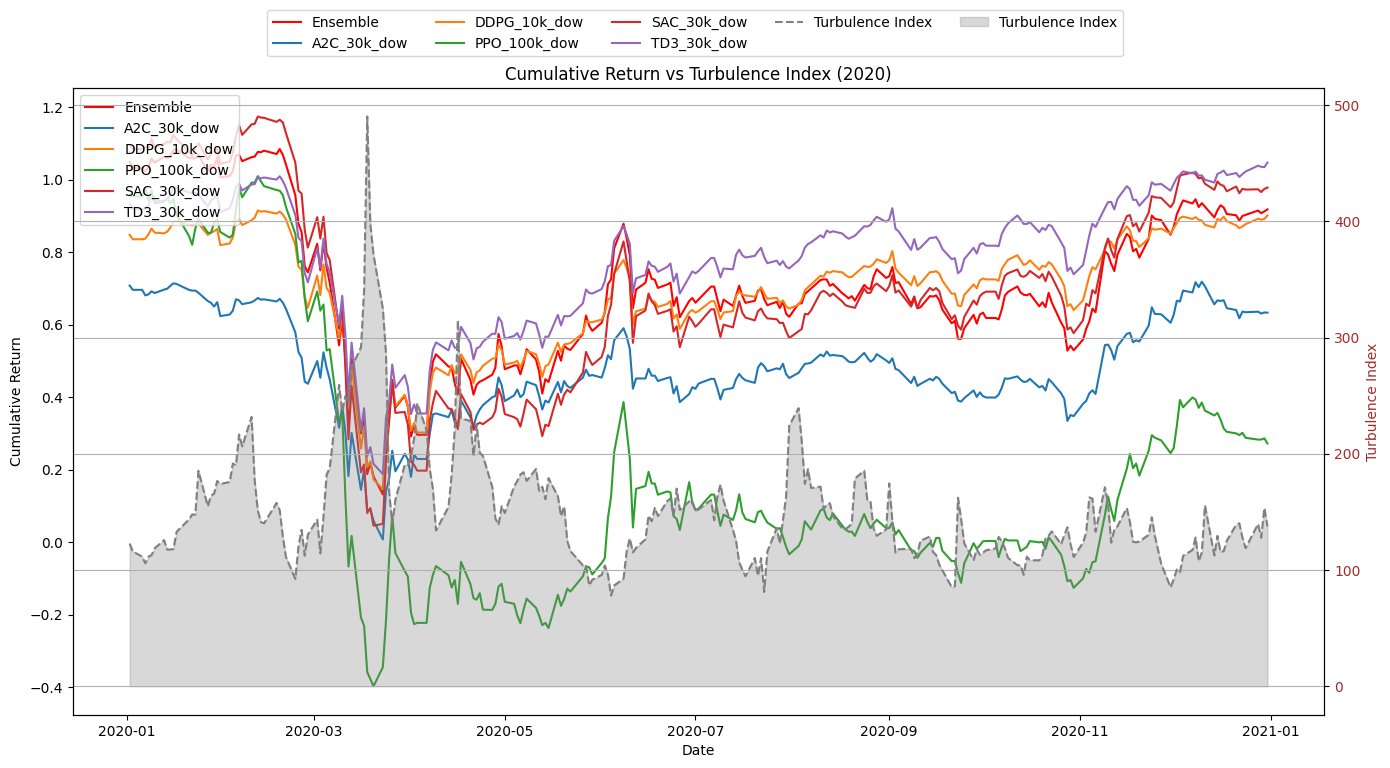

In [38]:
df['Date'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df_volatile = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2020-12-31')]

df_account_value_volatile = df_account_value[(df_account_value['datadate'] >= '2020-01-01') & (df_account_value['datadate'] <= '2020-12-31')]
df_agents_volatile = df_agents[(df_agents['Date'] >= '2020-01-01') & (df_agents['Date'] <= '2020-12-31')]

fig, ax1 = plt.subplots(figsize = (14, 7))
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return', color='black')
ax1.plot(df_account_value_volatile['datadate'], df_account_value_volatile['cumret'], linestyle='-', color='red', label='Ensemble')
# TODO: Add DJI Index
# ax1.plot(dji_data['Date'], dji_data['cumret'], linestyle='-', color='blue', label='DJI')

for name, group in df_agents_volatile.groupby('name'):
    ax1.plot(group['Date'], group['cumret'], linestyle='-', label=name)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Turbulence Index', color='brown')
ax2.plot(df_volatile['Date'], df_volatile['turbulence'], linestyle='--', color='gray', label='Turbulence Index')
ax2.fill_between(df_volatile['Date'], df_volatile['turbulence'], color='gray', alpha=0.3, label='Turbulence Index')
ax2.tick_params(axis='y', labelcolor='brown')

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)
plt.title('Cumulative Return vs Turbulence Index (2020)')
plt.grid()
plt.show()